# Phishing-Url-Detection-Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier


# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def convert_boolean_cols(df, columns):
  
  for col in columns:
    df[col] = df[col].apply(lambda x: 1 if x == True else 0)
  
  return df

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = sklearnPipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = sklearnPipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sklearn_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df


def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [3]:
legit_records, phishing_records = [], []
chunk_size = 10000
file_path = "/Users/maukanmir/Downloads/out.csv"
target_labels = ['legitimate', 'phishing']
target_count = 12500
legitimate_count = 0
phishing_count = 0

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    filtered_chunk = chunk[chunk['label'].isin(target_labels)]

    legitimate_chunk = filtered_chunk[filtered_chunk['label'] == 'legitimate']
    phishing_chunk = filtered_chunk[filtered_chunk['label'] == 'phishing']
    
    if legitimate_count < target_count:
        legit_needed = target_count - legitimate_count
        legit_records.append(legitimate_chunk[:legit_needed])
        legitimate_count += len(legitimate_chunk[:legit_needed])
    
    if phishing_count < target_count:
        phishing_needed = target_count - phishing_count
        phishing_records.append(phishing_chunk[:phishing_needed])
        phishing_count += len(phishing_chunk[:phishing_needed])
    
    if legitimate_count >= target_count and phishing_count >= target_count:
        break

final_legitimate_df = pd.concat(legit_records)
final_phishing_df = pd.concat(phishing_records)
df = pd.concat([final_legitimate_df, final_phishing_df])

In [4]:
df.describe()

,url_length,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,subdomain_count,nan_char_entropy,domain_age_days
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,18069.000000
mean,45.754120,3.907296,0.117739,2.193400,0.011440,0.74220,0.040800,0.798320,0.465772,4840.316675
std,73.999802,0.633720,0.244869,1.885115,0.127553,1.65887,0.397519,1.197707,0.188809,3344.289001
min,5.000000,1.750000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.097627,0.000000
25%,17.000000,3.452820,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.306397,1942.000000
50%,29.000000,3.913800,0.000000,2.000000,0.000000,0.00000,0.000000,1.000000,0.415452,4281.000000
75%,51.000000,4.323955,0.133333,3.000000,0.000000,1.00000,0.000000,1.000000,0.619279,7716.000000
max,4716.000000,5.987969,3.909091,109.000000,4.000000,118.00000,28.000000,35.000000,1.403592,14382.000000


# Check For Nulls And Dupes

In [5]:
check_for_nulls_dupes(df)

The amount of Null Values: url                      0
source                   0
label                    0
url_length               0
starts_with_ip           0
url_entropy              0
has_punycode             0
digit_letter_ratio       0
dot_count                0
at_count                 0
dash_count               0
tld_count                0
domain_has_digits        0
subdomain_count          0
nan_char_entropy         0
has_internal_links       0
whois_data            4613
domain_age_days       6931
dtype: int64
The amount of Duplicated Values 0


In [6]:
df.dtypes

url                    object
source                 object
label                  object
url_length              int64
starts_with_ip           bool
url_entropy           float64
has_punycode             bool
digit_letter_ratio    float64
dot_count               int64
at_count                int64
dash_count              int64
tld_count               int64
domain_has_digits        bool
subdomain_count         int64
nan_char_entropy      float64
has_internal_links       bool
whois_data             object
domain_age_days       float64
dtype: object

In [7]:
df["whois_data"].unique()

array(["{'domain_name': ['ARUBANETWORKS.COM', 'arubanetworks.com'], 'registrar': 'MarkMonitor, Inc.', 'whois_server': 'whois.markmonitor.com', 'referral_url': None, 'updated_date': ['2024-04-17T14:29:21.000', '2024-04-17T14:29:21.000Z'], 'creation_date': ['2002-02-06T02:15:38.000', '2002-02-06T02:15:38.000Z'], 'expiration_date': ['2026-02-06T02:15:38.000', '2026-02-06T00:00:00.000Z'], 'name_servers': ['NS-1473.AWSDNS-56.ORG', 'NS-1639.AWSDNS-12.CO.UK', 'NS-299.AWSDNS-37.COM', 'NS-751.AWSDNS-29.NET', 'ns-751.awsdns-29.net', 'ns-299.awsdns-37.com', 'ns-1639.awsdns-12.co.uk', 'ns-1473.awsdns-56.org'], 'status': ['clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited', 'clientTransferProhibited https://icann.org/epp#clientTransferProhibited', 'clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited', 'serverDeleteProhibited https://icann.org/epp#serverDeleteProhibited', 'serverTransferProhibited https://icann.org/epp#serverTransferProhibited', 'serverUpdateProhibi

In [8]:
print(df["domain_age_days"].mean())

4840.316674968178


In [9]:
print(df["domain_age_days"].median())

4281.0


# Check Class Imbalance

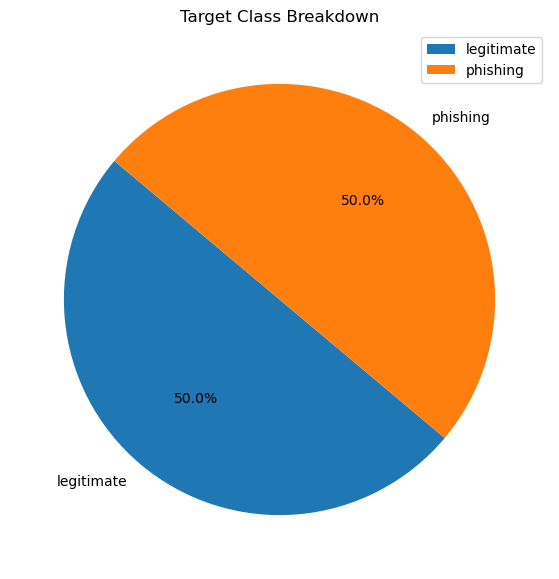

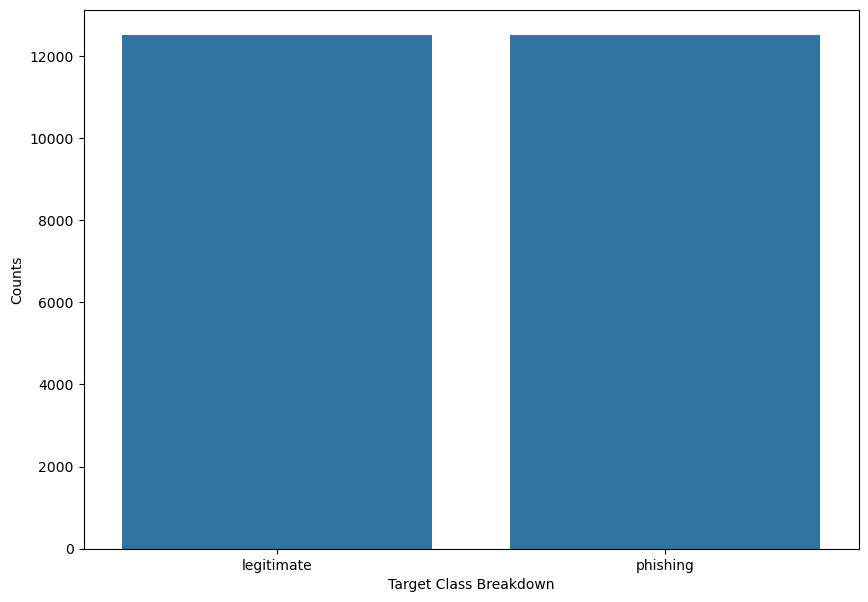

In [10]:
check_class_imbalance(df["label"])

In [11]:
df.drop("whois_data", axis=1, inplace=True)

In [12]:
categorical_types = df.select_dtypes(include="object").drop(["label", "url"], axis=1)
numerical_types = df.select_dtypes(exclude="object")

In [13]:
boolean_types = numerical_types.select_dtypes(include="bool").columns
numerical_types = convert_boolean_cols(numerical_types, boolean_types)

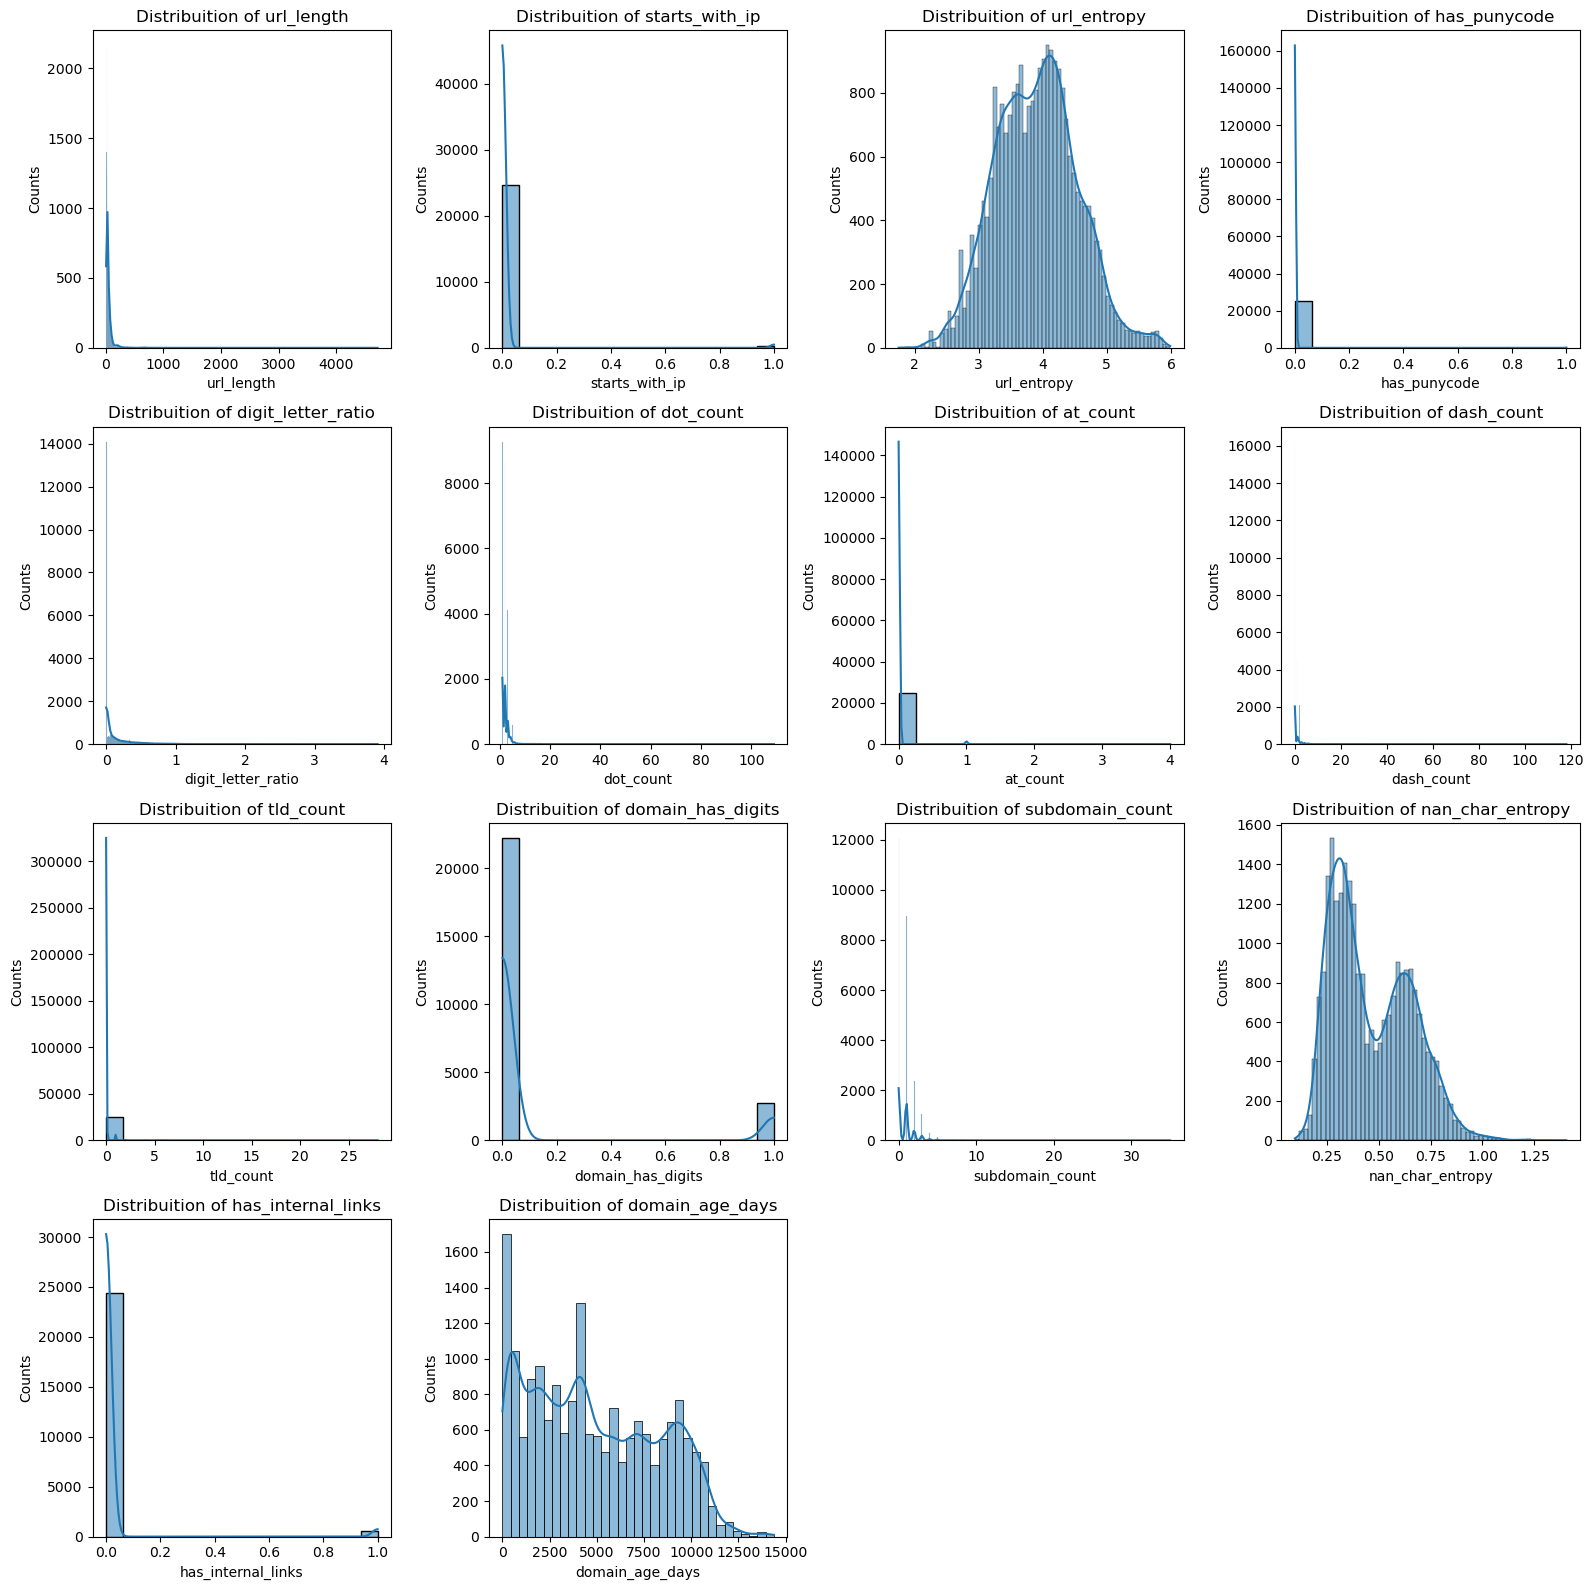

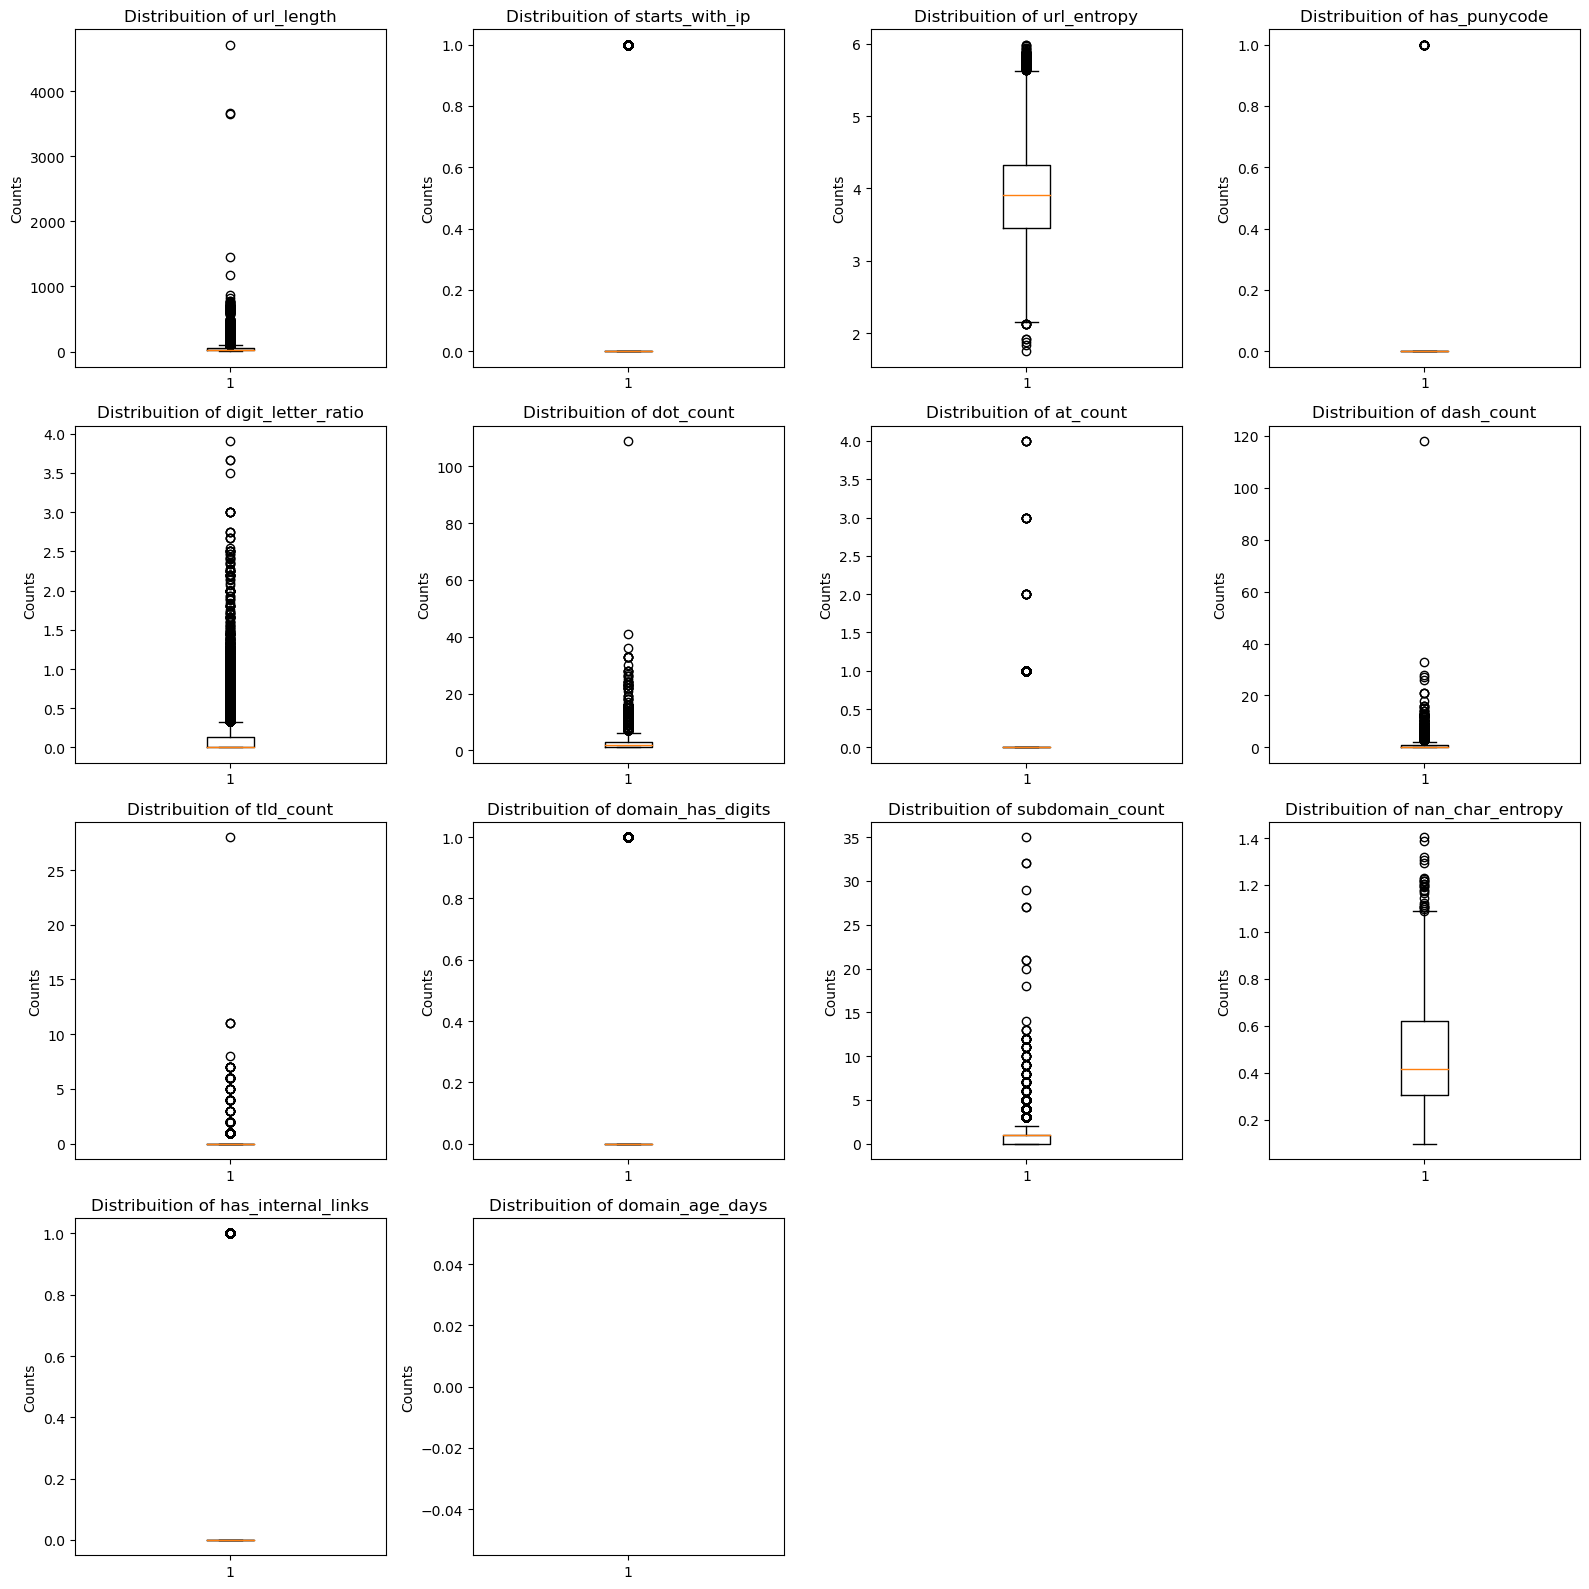

In [14]:
plot_distribution(numerical_types, "hist")
plot_distribution(numerical_types, "box")

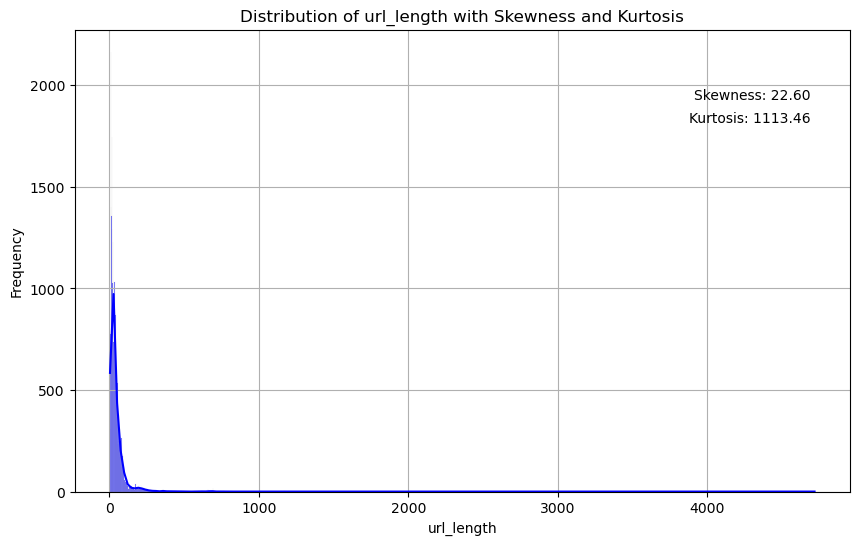

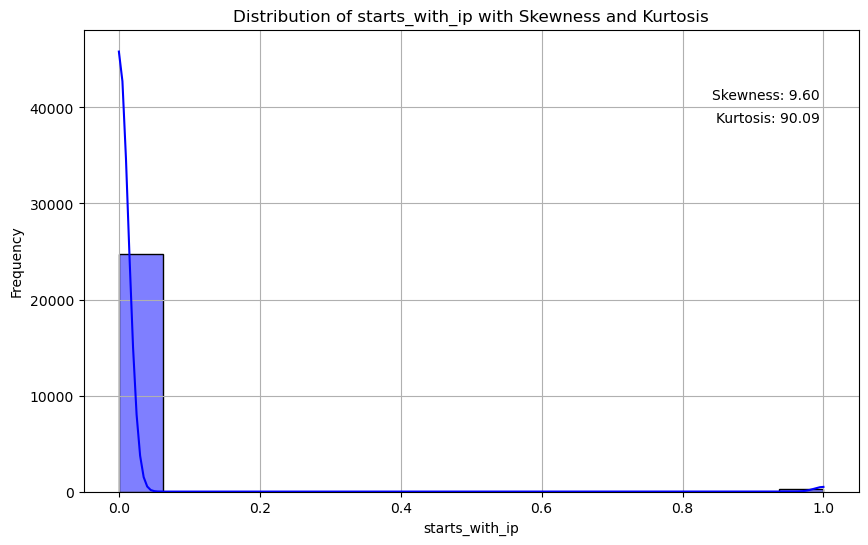

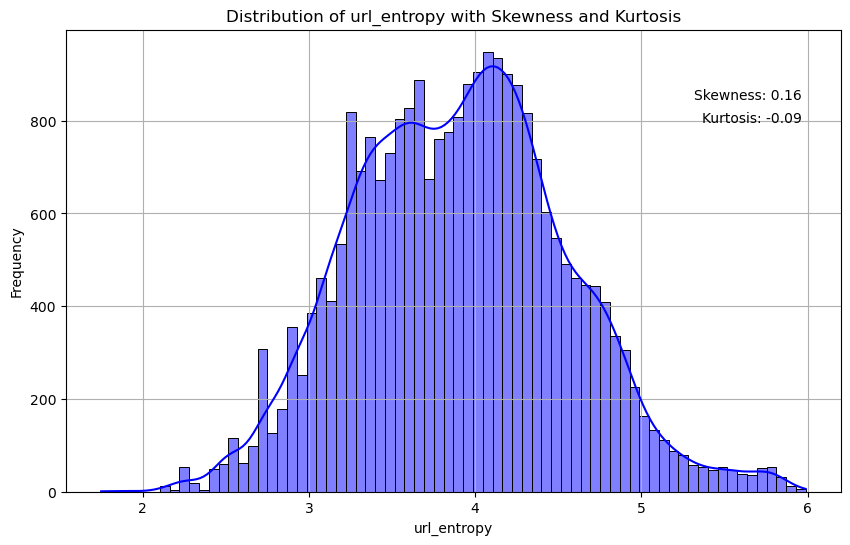

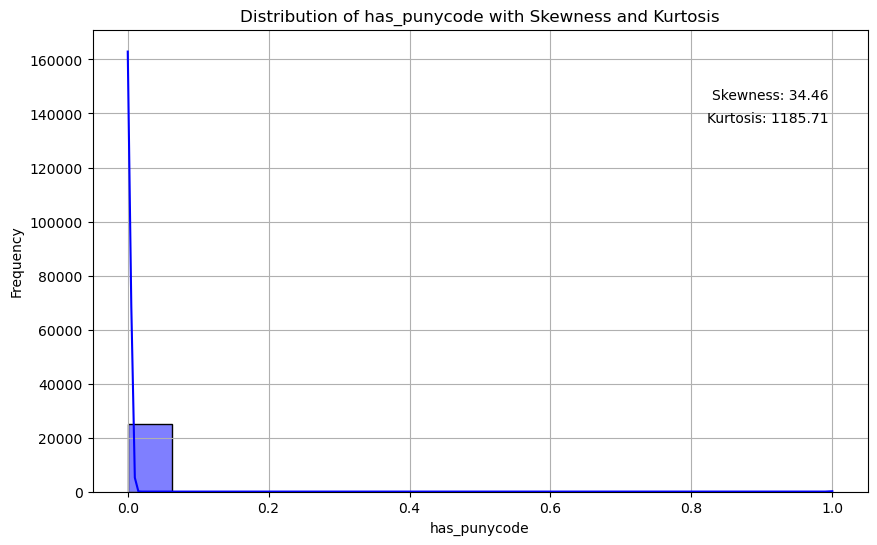

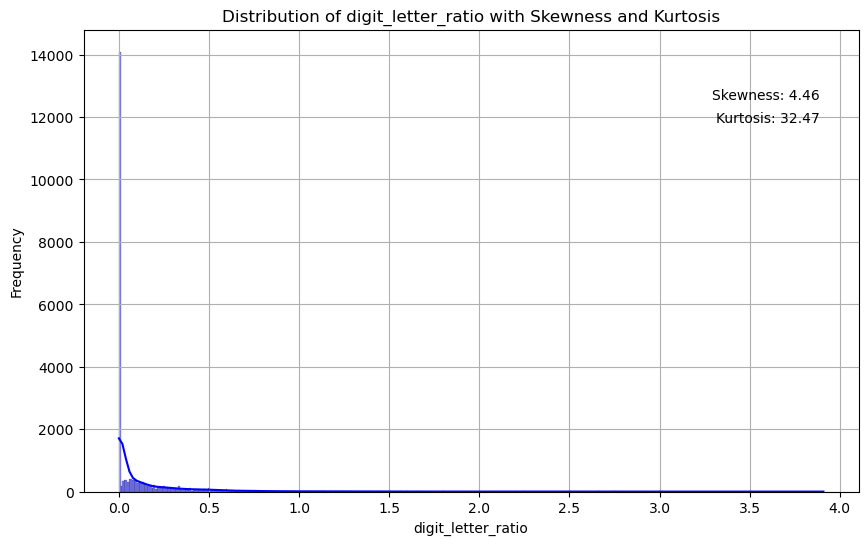

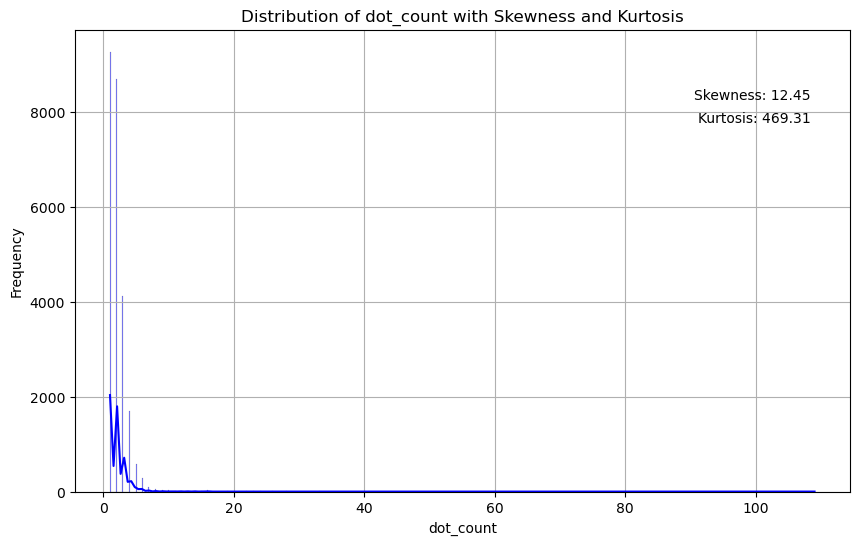

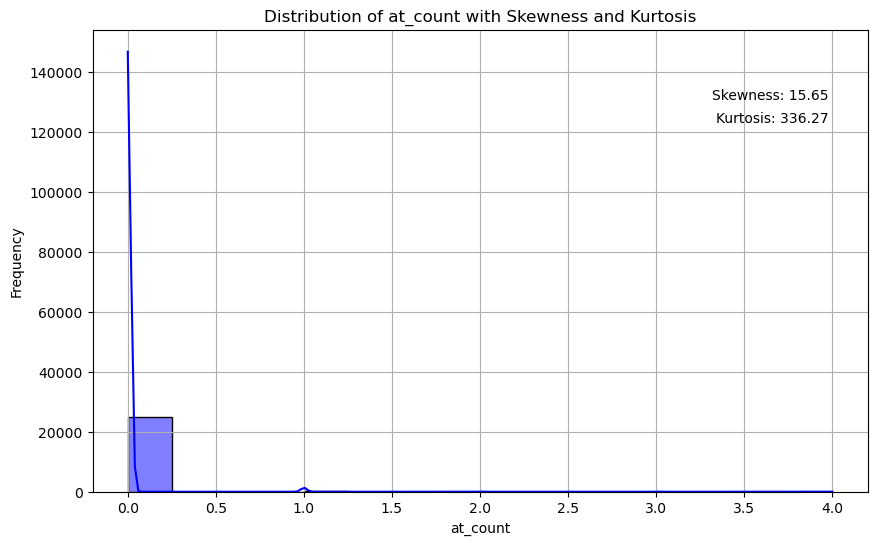

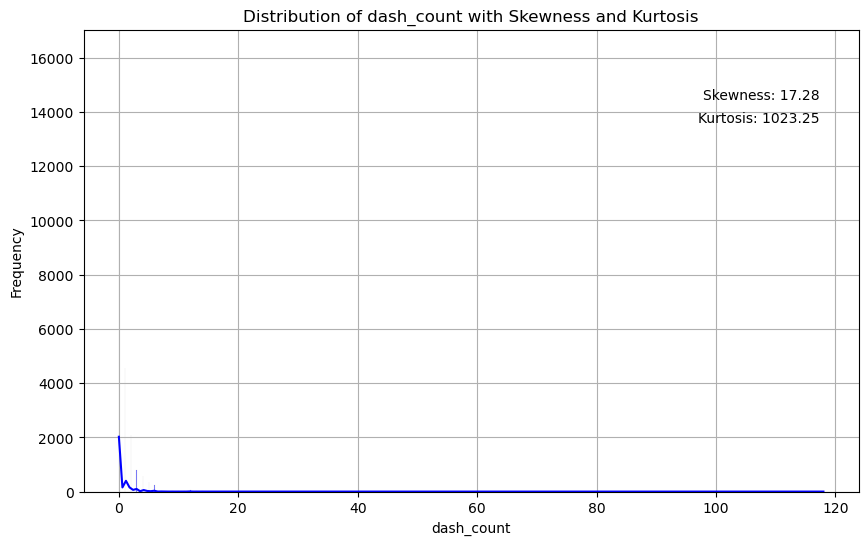

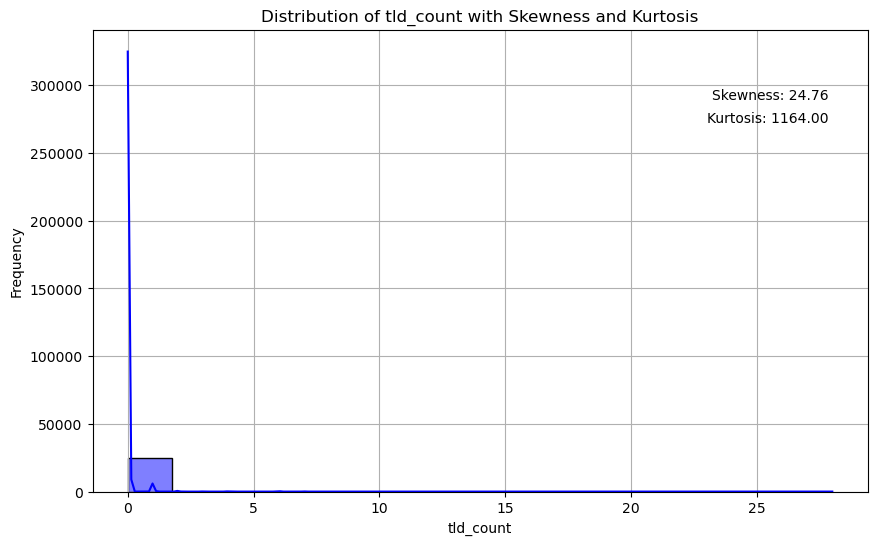

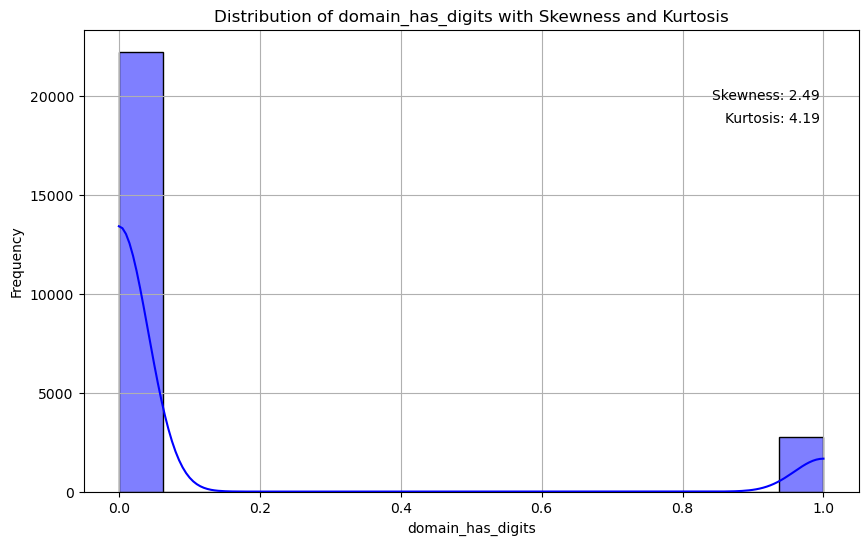

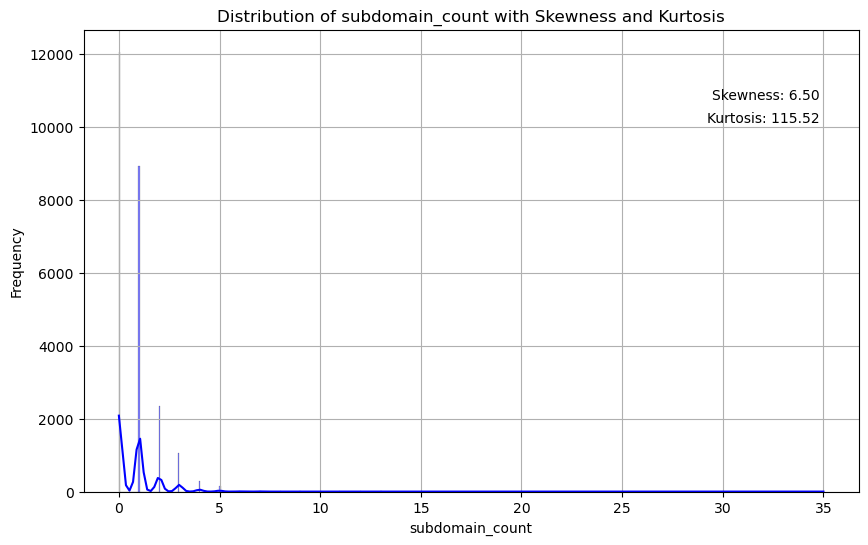

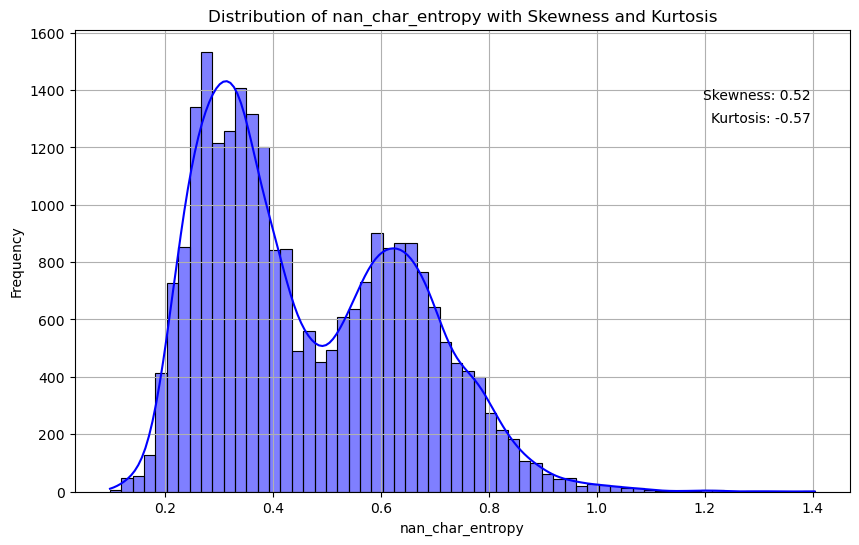

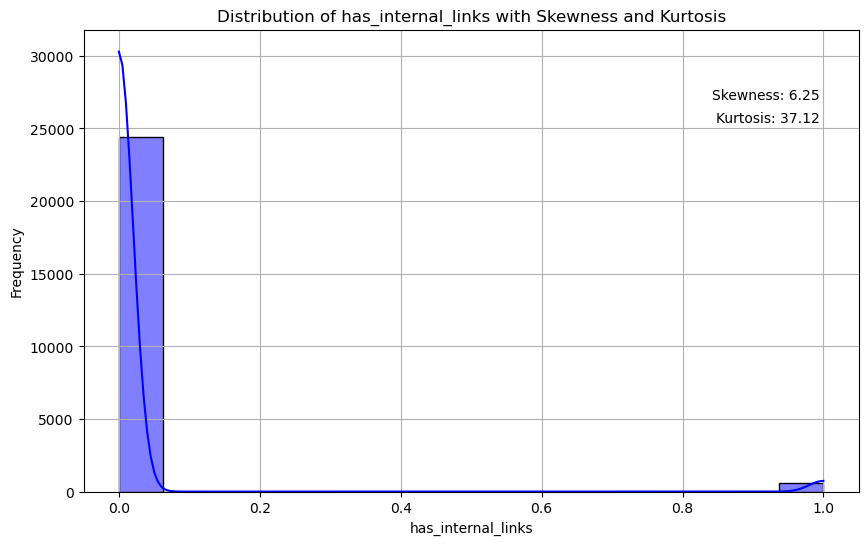

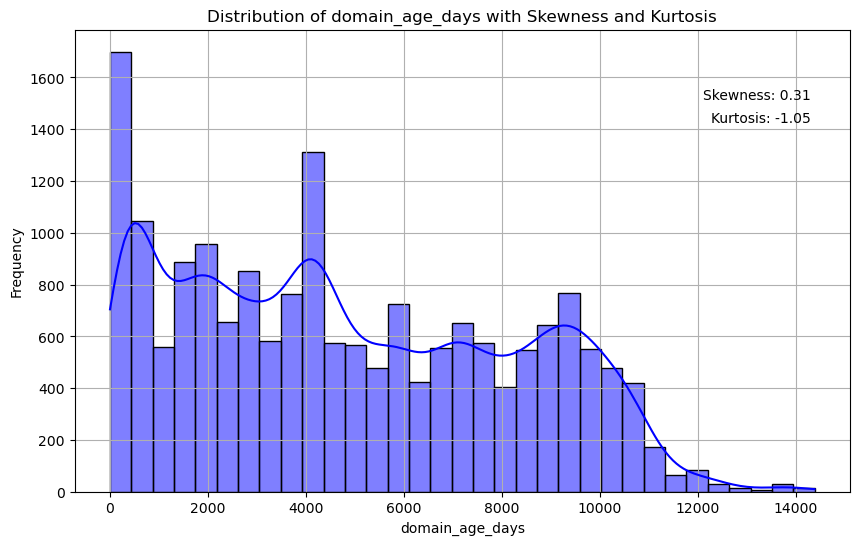

In [15]:
dist_plot(numerical_types)

In [16]:
mean = df["domain_age_days"].mean()
df["domain_age_days"] = df["domain_age_days"].fillna(mean)

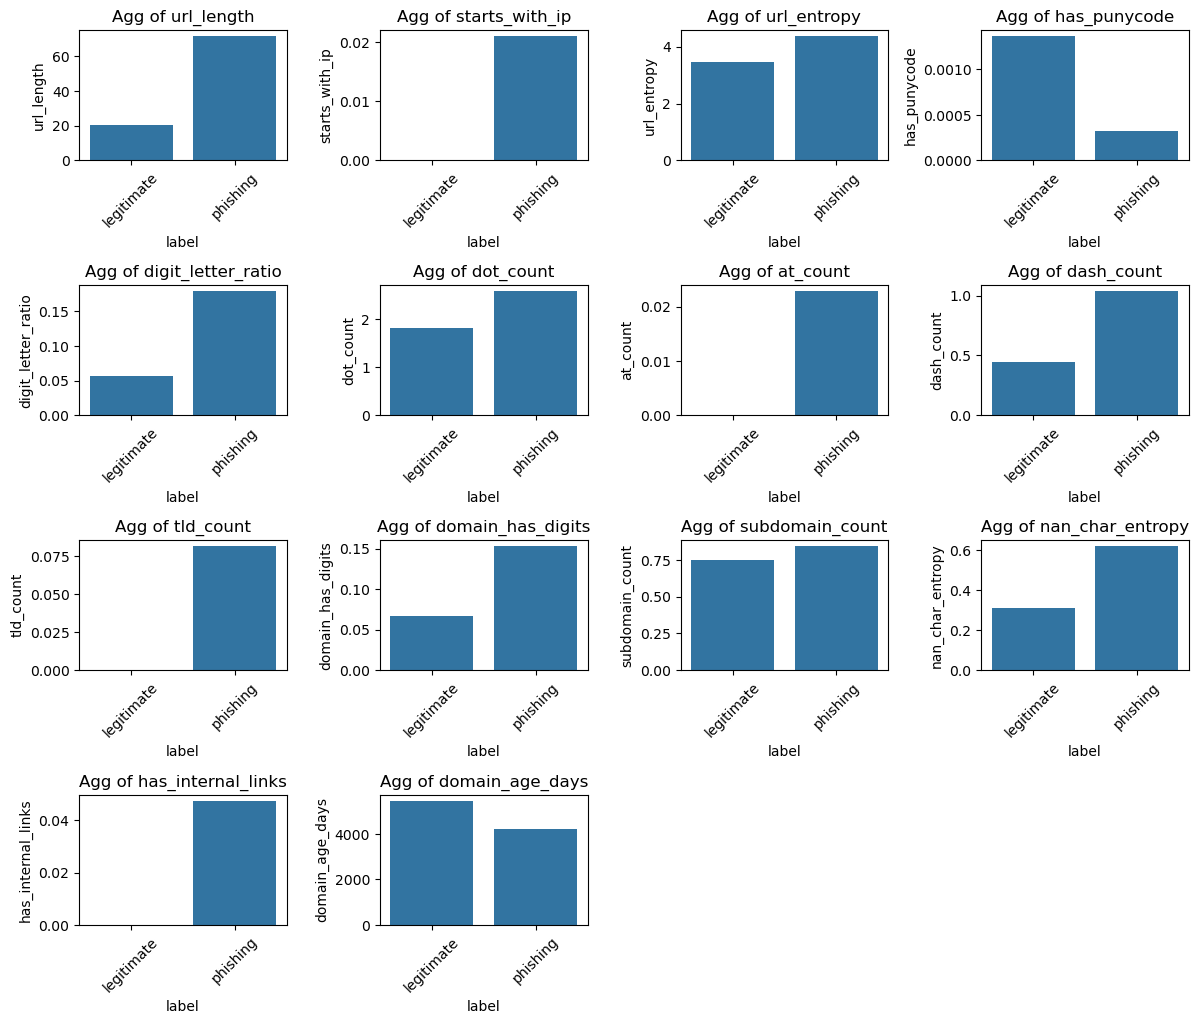

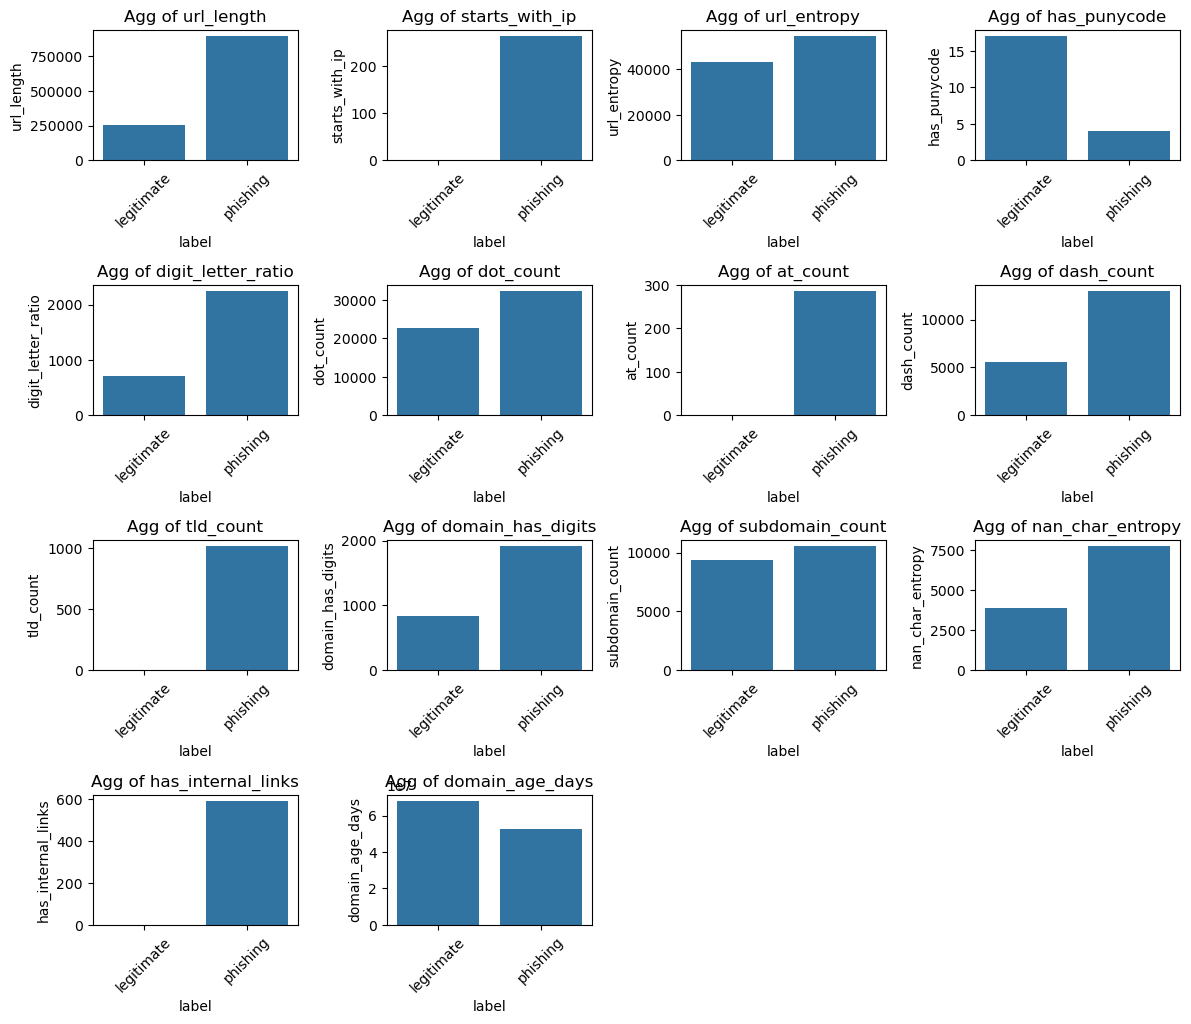

In [17]:
aggregate_dataset(df, numerical_types.columns, "label" ,"mean")
aggregate_dataset(df, numerical_types.columns, "label" ,"sum")

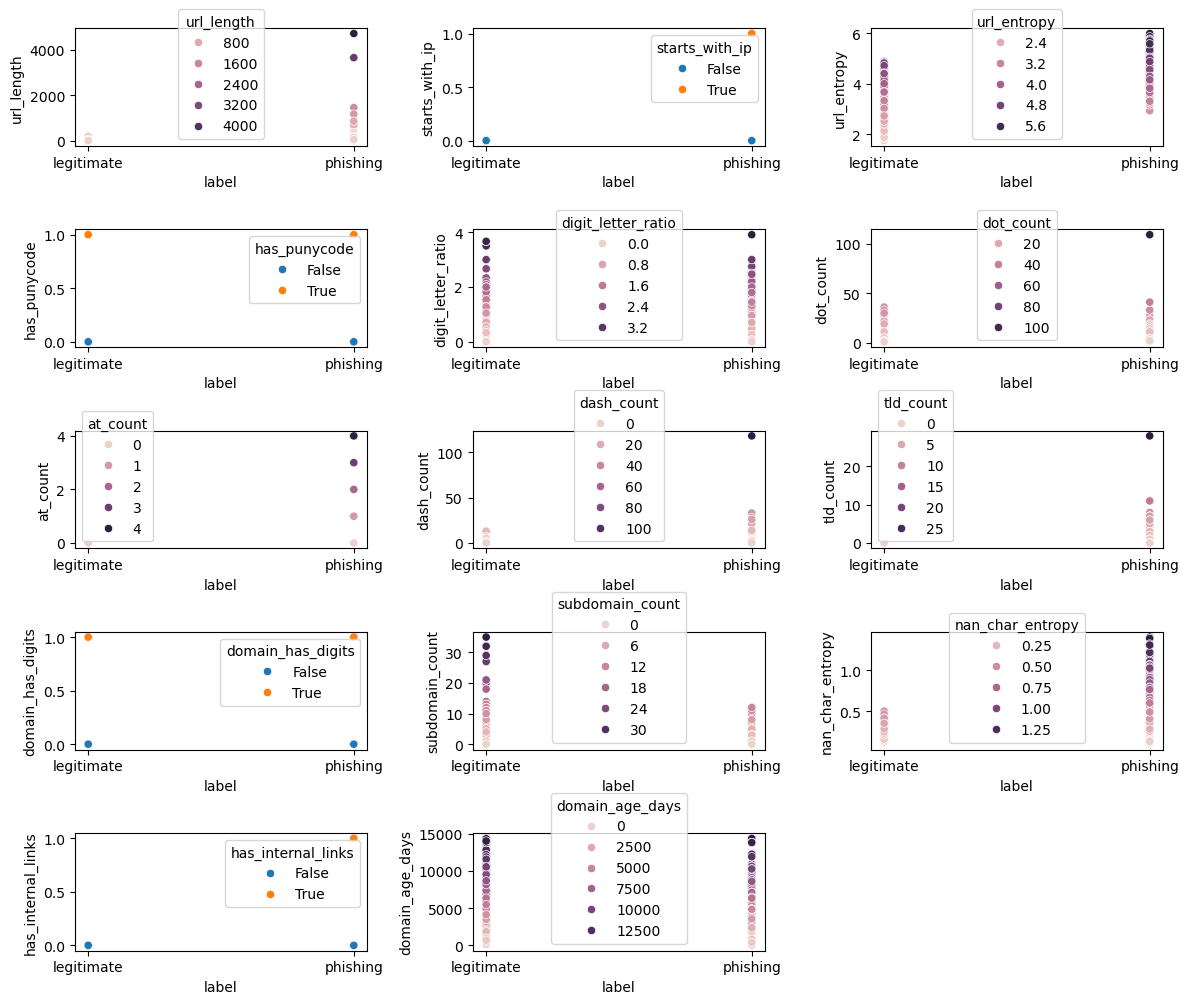

In [18]:
scatter_plot(df, numerical_types.columns, "label")

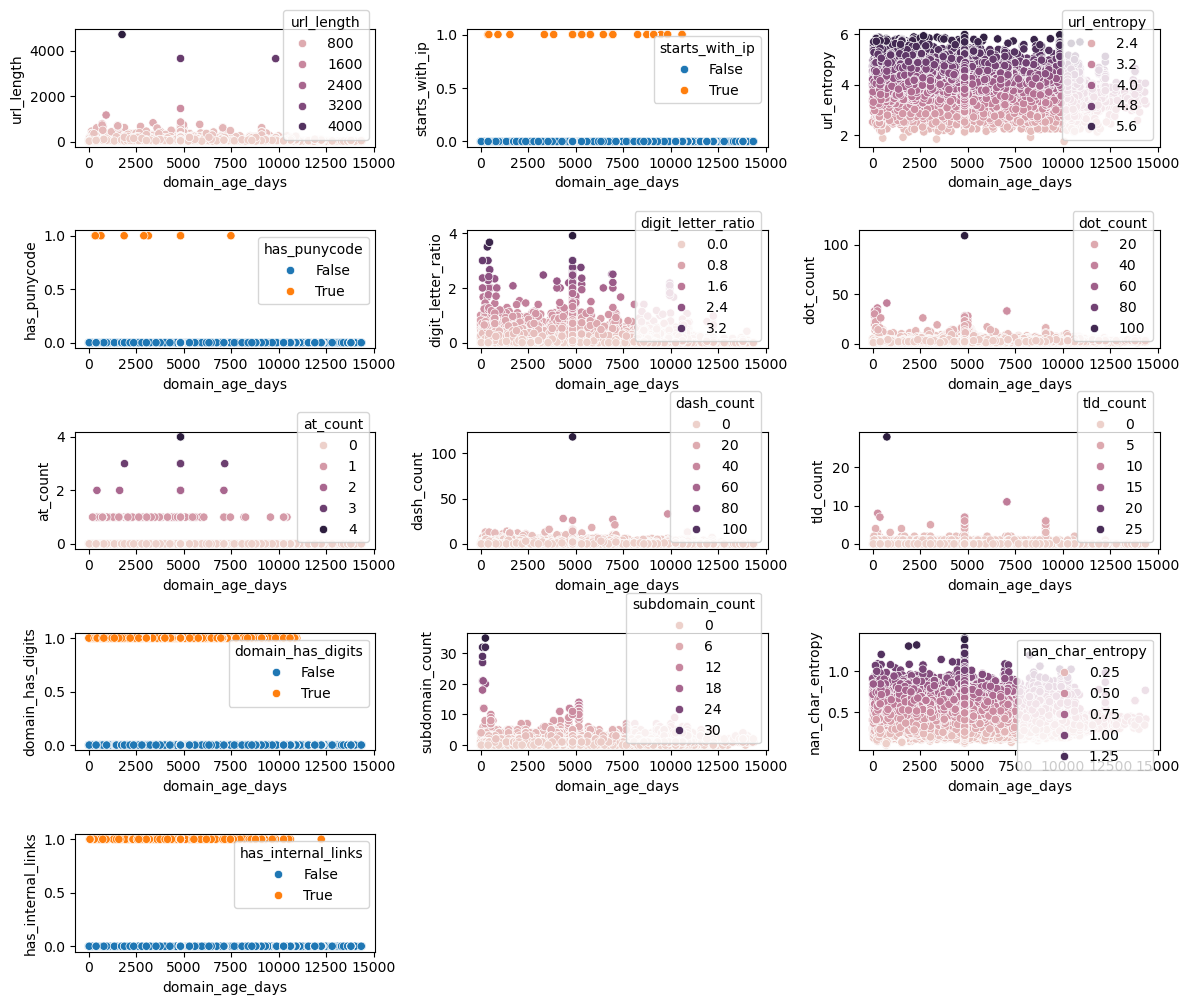

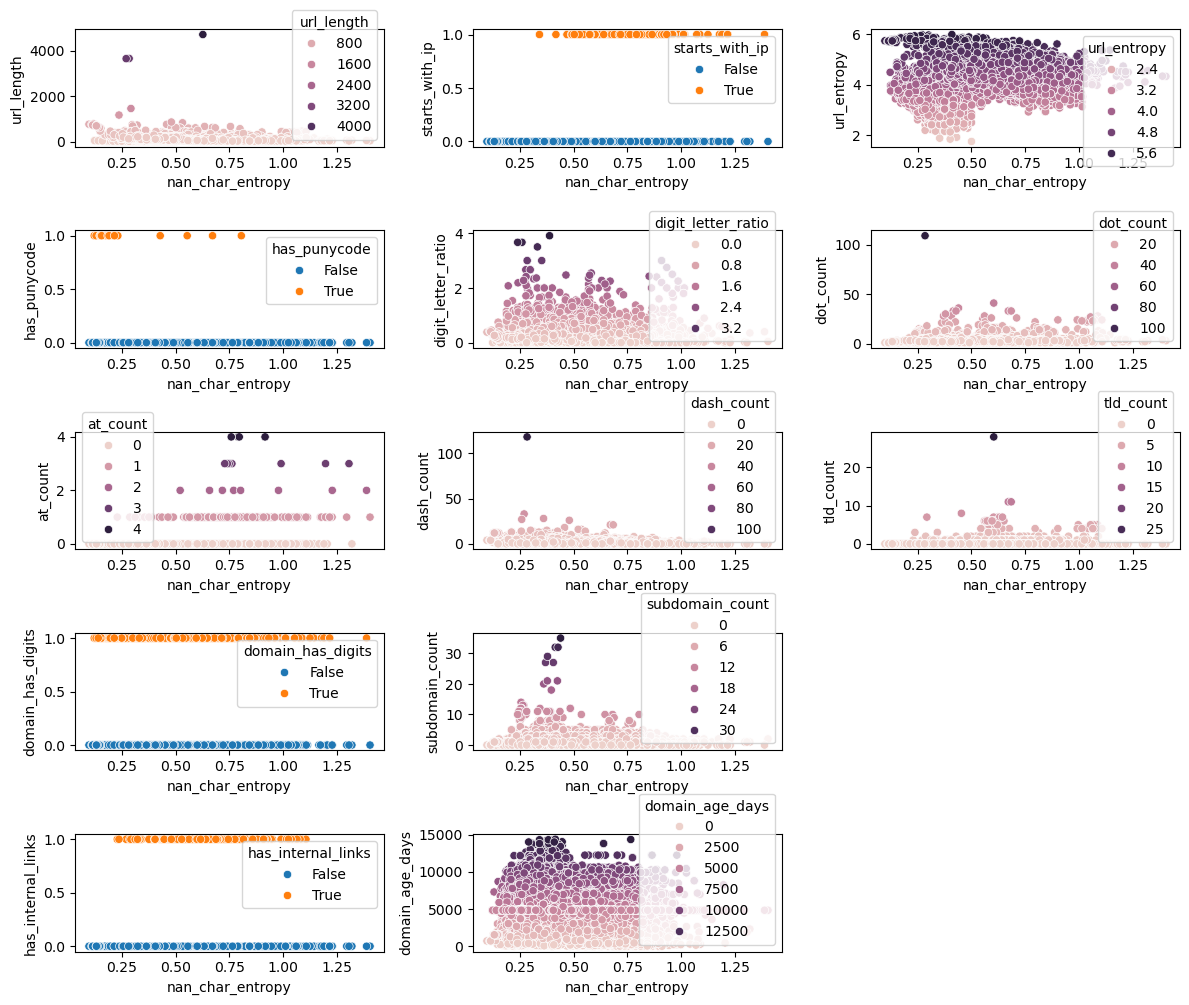

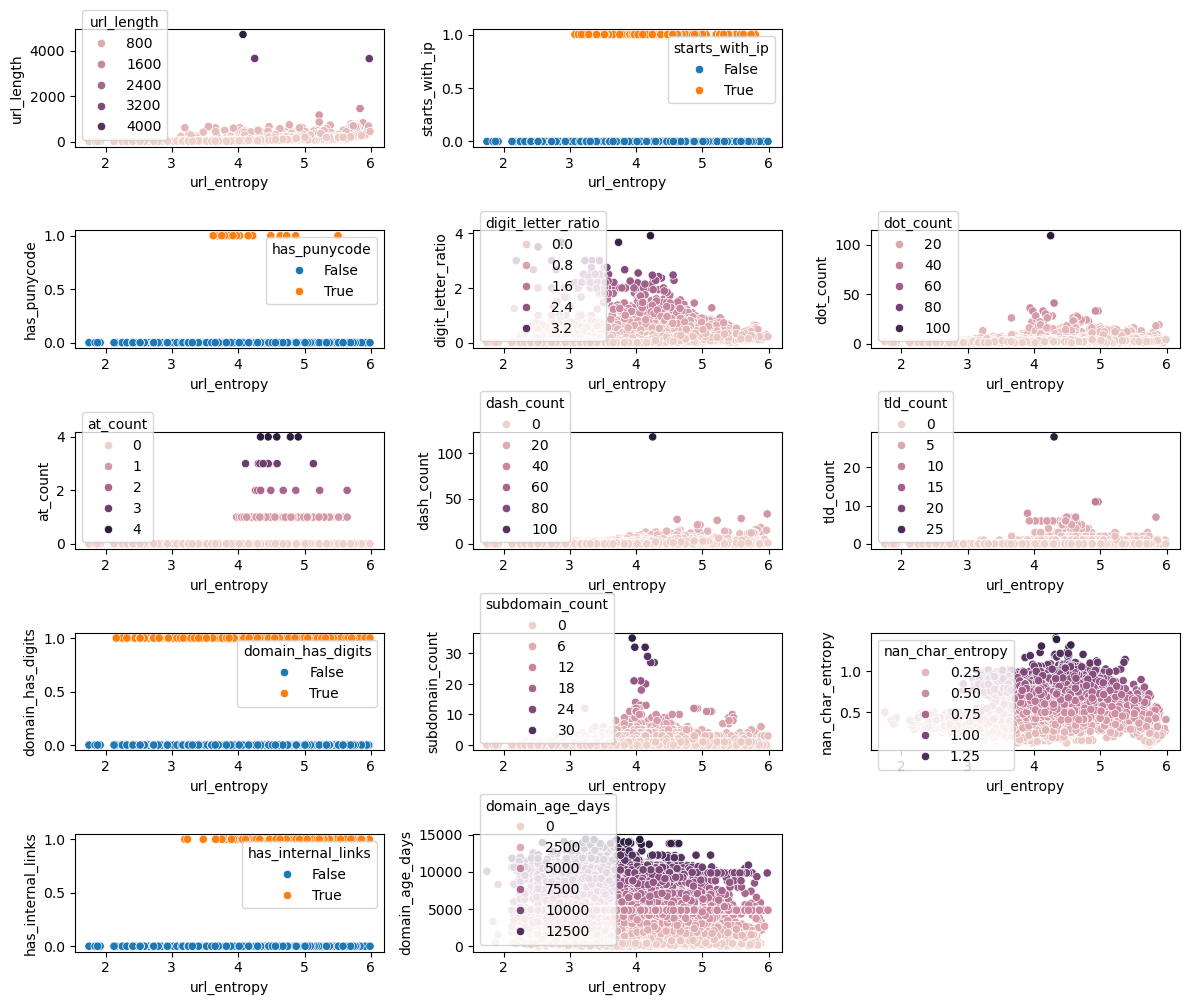

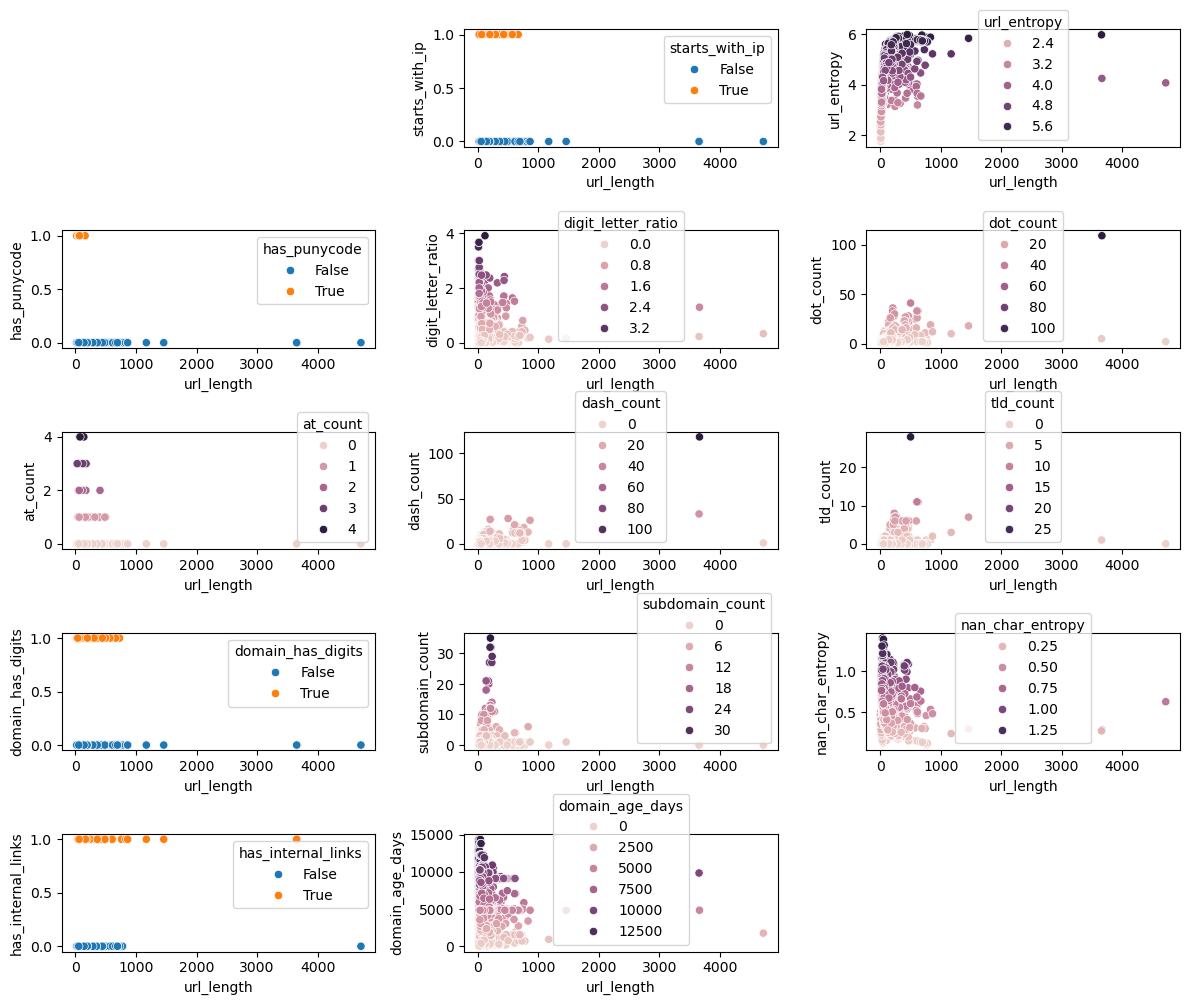

In [19]:
scatter_plot(df, numerical_types.columns, "domain_age_days")
scatter_plot(df, numerical_types.columns, "nan_char_entropy")
scatter_plot(df, numerical_types.columns, "url_entropy")
scatter_plot(df, numerical_types.columns, "url_length")

# Heat Map

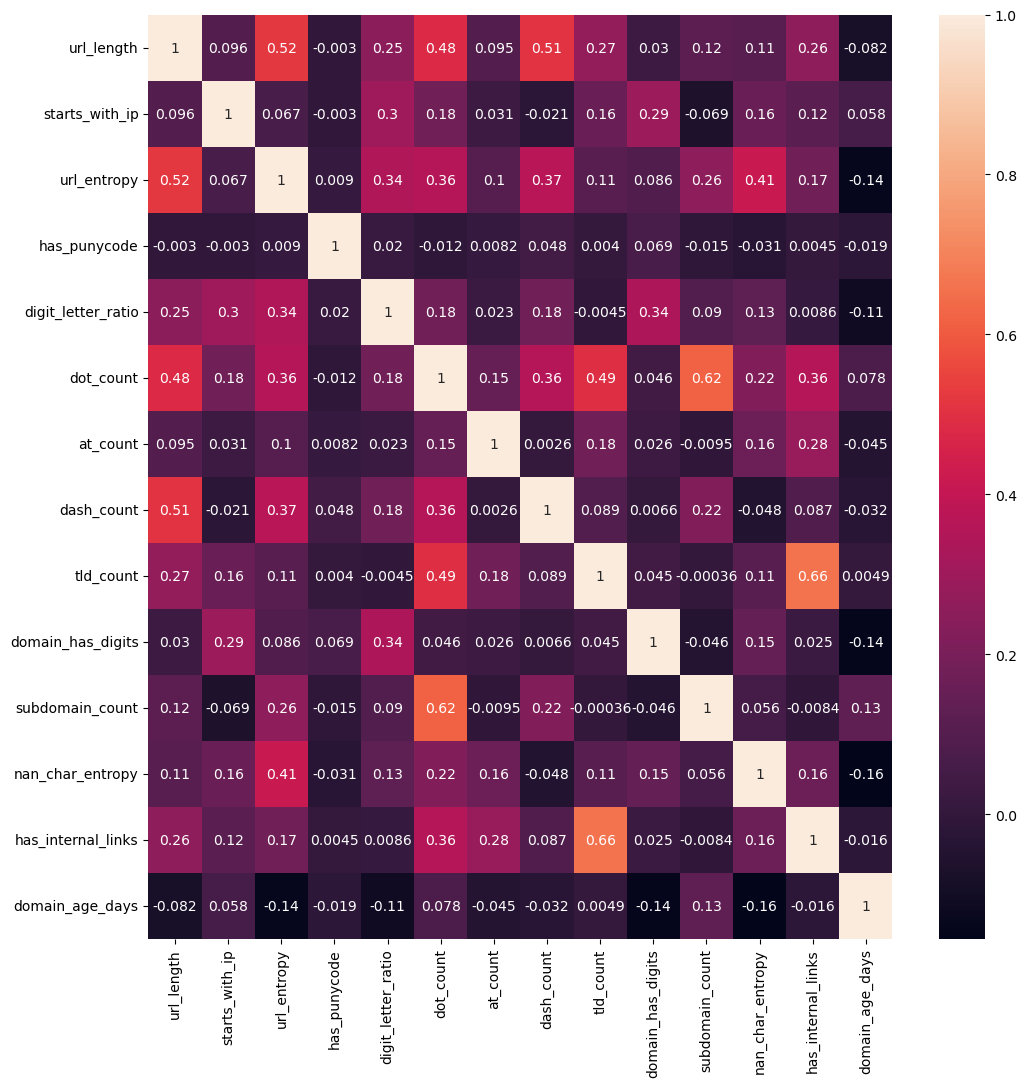

In [20]:
relations = numerical_types.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(data=relations, annot=True)
plt.show()

In [27]:
categorical_types

,url,source
0,apaceast.cloudguest.central.arubanetworks.com,Cisco-Umbrella
1,quintadonoval.com,Majestic
2,nomadfactory.com,Majestic
3,tvarenasport.com,Majestic
4,widget.cluster.groovehq.com,Cisco-Umbrella
...,...,...
1262495,https://yilmazsakatat.com/credem,Phishing.Database
1262496,https://arnz.bhmymw.rest,Phishing.Database
1262497,http://iauosnvva.com,Phishing.Database
1262498,http://join-chat-whatsapp.getflx93.ml,Phishing.Database


# Create Preprocessor

In [21]:
preprocessor = create_column_transformer(categorical_types.columns, numerical_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['url', 'source'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['url_length', 'starts_with_ip', 'url_entropy', 'has_punycode',
       'digit_letter_ratio', 'dot_count', 'at_count', 'dash_count',
       'tld_count', 'domain_has_digits', 'subdomain_count', 'nan_char_entropy',
       'has_internal_links', 'domain_age_days'],
      dtype='object'))])

# Separate Features

In [22]:
X = df.drop("label", axis=1)
y = df["label"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

In [23]:
pca_analysis(X, preprocessor)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.